In [1]:
from __future__ import with_statement
from contextlib import contextmanager
import sys
import os

sys.path.append(r"C:\Program Files\PTI\PSSE35\35.2\PSSBIN")
os.environ['PATH'] = (r"C:\Program Files\PTI\PSSE35\35.2\PSSBIN;" + os.environ['PATH'])
sys.path.append(r"C:\Program Files\PTI\PSSE35\35.2\PSSPY38")
os.environ['PATH'] = (r"C:\Program Files\PTI\PSSE35\35.2\PSSPY38;" + os.environ['PATH'])
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pssepath
import pandas as pd
import numpy as np
import psse35
pssepath.add_pssepath()
import psspy
import redirect
import dyntools
import pssplot
import random
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from pytictoc import TicToc
import re
import shutil
import math

    Sets PSSE environment to latest minor version among installed versions of PSSE 35.
    Use psse35.set_minor(n) to set PSSE35 minor version (n) to use.
        Example, for PSSE 35.0.x, use this as: psse35.set_minor(0)


In [2]:
@contextmanager
def silence(file_object=None):
    """
    Discard stdout (i.e. write to null device) or
    optionally write to given file-like object.
    """
    if file_object is None:
        file_object = open(os.devnull, 'w')

    old_stdout = sys.stdout
    try:
        sys.stdout = file_object
        yield
    finally:
        sys.stdout = old_stdout


def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)
        
def txtoutdelete(directory):
    for (path, dir, files) in os.walk(directory):
        for filename in files:
            ext = os.path.splitext(filename)[-1]
            #print(ext)
            if ext == '.txt' or ext == '.out':
                try:
                    os.remove(path + '/' + filename)
                except:
                    break
                #print('yes')

def clean_text(text):
    cleaned_text = re.sub('[\{\}\[\]\/?,;:|\)*~`!^\_+<>@\#$%&\\\=\(\'\"\♥\♡\ㅋ\ㅠ\ㅜ\ㄱ\ㅎ\ㄲ\ㅡ]', '', text)
    return cleaned_text

In [3]:
# Redirect output from PSSE to Python:
redirect.psse2py()

# Last case:

folder = 'C:/Users/smartgrid_AI/Desktop/netzero/case'
savefolder = 'C:/Users/smartgrid_AI/Desktop/netzero/case'
runfolder = 'C:/Users/smartgrid_AI/Documents/kms/netzero'
name = 'SMIBPLB_TEST'  
rawfile = folder+'/'+name+'.raw'
dynfile = folder+'/'+'SMIB34_ori'+'.dyr'
outfile = 'base' + '.out'
txtfile = 'base' + '.txt'
OUTDIR = savefolder + '/' + outfile

In [4]:
# User-dependent variable
MVAbase = 3
Prated = 3/MVAbase #(3MW)
Anum = 3 # 3, 5, 6, 7, 8, 10, 11, 12
Cnum = 1
timestep = 0.008333

## Initial Icon Values
## Volage Control
POIFLAG = 0 # 0: Voltage control at the bus before transformer / 1: POI voltage ctrl (after transformer)
if POIFLAG == 0:
    BusVC = 0
    Fmonb = 0
    Tmonb = 0
    Bcid = 0
else:
    BusVC = 2
    Fmonb = 2
    Tmonb = 1
    Bcid = 1
    
## REECA ICONs
PFFLAG = 0 # 1: Power factor ctrl / 0: Plant Q ctrl
PFLAG = 0  # 1: With WTDTAU1 / 0: Without WTDTAU1
PQFLAG = 0 # 1: P Priority / 0: Q Priority

## REPCA ICONs
VCFLAG = 1 # 1: Line Drop Compensation / 0: Droop 
REFFLAG = 1 # 1: Voltage ctrl / 0: Q ctrl

In [5]:
p0=1
gen_bus_num = 1
poi_bus_num = 2
inf_bus_num = 4
Pini = Prated*MVAbase*p0
from psspy import _i, _f, _s

psspy.psseinit(500000)
psspy.read(0, rawfile)
psspy.dyre_new([1,1,1,1], dynfile,"","","")

ORI_REGCA = np.array([0.02, 10, 0.9, 0.4, 1.22, 1.2, 0.8, 0.4, -1.2, 0.02, 0.7, 1.2, -1.2, 0.7], dtype=np.float32)
ORI_REECA = np.array([0.9, 1.1, 0.02, 0.05, 0.05, 3, 1, -1, 0, 0, 0, 0, 0.2, 1, -1, 1.1, \
                      0.9, 0, 1, 0, 1, 0, 0, 999, -999, 1, 0, 1.2, 0, 0, 0, 0.49, \
                     0, 0.5, 1, 1.2, 1, 0, 0, 0.49, 0, 0.5, 1, 1.2, 1], dtype=np.float32)
ORI_REPCA = np.array([0.02, 0, 0.5, 0, 0, 0.7, 0, 0, 0, 0.1, -0.1, 0, 0, 1, -1, 0, 0.5, \
                     0.02, -0.0006, 0.0006, 999, -999, 1, 0, 0.2, 20, 20])
ORI_WTDTA = np.array([3, 0, 0.5, 60, 1])
ORI_FRQTPAT = np.array([58, 62, 0.1, 0.08])
ORI_VTGTPAT = np.array([0.4, 1.3, 0.1, 0.08])
REECA_Icon = np.array([0, PFFLAG, 0, 0, PFLAG, PQFLAG], dtype=np.int32)
REPCA_Icon = np.array([BusVC, Fmonb, Tmonb, Bcid, VCFLAG, REFFLAG, 1], dtype=np.int32)


for i in range(REECA_Icon.shape[0]):
    psspy.change_wnmod_icon(1,r"""1""",r"""REECA1""", i+1, REECA_Icon[i])
for i in range(REPCA_Icon.shape[0]):
    psspy.change_wnmod_icon(1,r"""1""",r"""REPCA1""", i+1, REPCA_Icon[i])

for i in range(ORI_REGCA.shape[0]):
        #psspy.change_ldmod_con(41, r"""16""", r"""CMLDBLDGU2""", Par_num[i]+1, X[i])
    psspy.change_wnmod_con(gen_bus_num,r"""1""",r"""REGCA1""",i+1, ORI_REGCA[i])
for i in range(ORI_REECA.shape[0]):        
    psspy.change_wnmod_con(gen_bus_num,r"""1""",r"""REECA1""",i+1, ORI_REECA[i])
for i in range(ORI_REPCA.shape[0]):        
    psspy.change_wnmod_con(gen_bus_num,r"""1""",r"""REPCA1""",i+1, ORI_REPCA[i])
for i in range(ORI_WTDTA.shape[0]):        
    psspy.change_wnmod_con(gen_bus_num,r"""1""",r"""WTDTA1""",i+1, ORI_WTDTA[i])
for i in range(ORI_FRQTPAT.shape[0]):        
    psspy.change_cctmscomod_con(r"""FRQTPAT""",1, i+1, ORI_FRQTPAT[i])
    psspy.change_cctmscomod_con(r"""VTGTPAT""",2,i+1,ORI_VTGTPAT[i])

psspy.machine_chng_3(1,r"""1""",[_i,_i,_i,_i,_i,_i,_i],[Pini,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f])
psspy.machine_chng_3(1,r"""1""",[_i,_i,_i,_i,_i,_i,_i],[_f,_f,_f,_f, Pini,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f])
psspy.machine_chng_3(1,r"""1""",[_i,_i,_i,_i,_i,_i,_i],[_f,_f,_f,_f,_f, -Pini,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f])
psspy.machine_chng_3(4,r"""1""",[_i,_i,_i,_i,_i,_i,_i],[-Pini,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f,_f])

# Converging and Converting:
psspy.fnsl([0,0,0,1,1,0,99,0])
psspy.fnsl([0,0,0,1,1,0,99,0])
psspy.cong(0)
psspy.conl(0,1,1,[0,0],[ 100.0,0.0,0.0, 100.0])
psspy.conl(0,1,2,[0,0],[ 100.0,0.0,0.0, 100.0])
psspy.conl(0,1,3,[0,0],[ 100.0,0.0,0.0, 100.0])
#psspy.fdns([0,0,0,1,1,0,99,0])
psspy.ordr(0)
psspy.fact()
psspy.tysl(0)

# Change Solution Time Step
psspy.dynamics_solution_param_2([_i,_i,_i,_i,_i,_i,_i,_i],[_f,_f, timestep,_f,_f,_f,_f,_f])
#psspy.dynamics_solution_param_2([_i,_i,_i,_i,_i,_i,_i,_i],[_f,_f, 0.00025,_f,_f,_f,_f,_f])

# Channel Setting
psspy.chsb(0,1,[-1,-1,-1,1,1,0])
psspy.chsb(0,1,[-1,-1,-1,1,2,0])
psspy.chsb(0,1,[-1,-1,-1,1,3,0])
psspy.chsb(0,1,[-1,-1,-1,1,21,0])
psspy.chsb(0,1,[-1,-1,-1,1,12,0])
psspy.chsb(0,1,[-1,-1,-1,1,14,0])
psspy.chsb(0,1,[-1,-1,-1,1,16,0])

# Initialize
psspy.set_chnfil_type(0)

psspy.strt_2([0,0],OUTDIR)
psspy.change_wnmod_var(1,r"""1""",r"""REPCA1""",4, p0)
psspy.run(0,20.0,0,1,0)
psspy.change_channel_out_file(OUTDIR)

achnf=dyntools.CHNF(str(OUTDIR))
achnf.txtout()
shutil.move(runfolder+'/'+txtfile, savefolder+'/'+txtfile)
#achnf.xlsout(show=False, xlsfile='', outfile='', sheet='Result', overwritesheet=True)
run = 1
psspy.progress_output(1)
psspy.delete_all_plot_channels()
psspy.dynamicsmode(0)
ierr_close_line = psspy.close_powerflow()
ierr_del_tmpfiles = psspy.deltmpfiles()


 Input error detected at !
 -m ipykernel_launcher -f C:\Users\smartgrid_AI\AppData\Roaming\jupyter\runtime\kernel-b95d6a62-ee64-4e7b-b54d-3408e8ec5359.json
                          !

 PSS(R)E Version 35
 Copyright (c) 1976-2024
 Siemens Industry, Inc.,
 Power Technologies International                            (PTI)
 This program is a confidential  unpublished  work  created  and  first
 licensed in 1976.  It is a trade secret which is the property of  PTI.
 All use,  disclosure,  and/or reproduction not specifically authorized
 by  PTI  is prohibited.   This  program is protected  under  copyright
 laws  of  non-U.S.  countries  and  by  application  of  international
 treaties.  All  Rights  Reserved  Under  The  Copyright  Laws.


           SIEMENS POWER TECHNOLOGIES INTERNATIONAL

      200000 BUS POWER SYSTEM SIMULATOR--PSS(R)E-35.2.1

             INITIATED ON TUE, OCT 01 2024  15:58

 Reading IC, SBASE, REV, XFRRAT, NXFRAT, BASFRQ...

 Converting RAW data from PSS(R)E 34 t

In [18]:
Idata = np.loadtxt(savefolder+'/'+txtfile, skiprows=8, dtype='float')   
time = np.array(Idata[:, 0])
Vgrid = np.array(Idata[:, 19])
fgrid = np.array(Idata[:, 12])
P = np.array(Idata[:, 3])
Q = np.array(Idata[:, 5])
df = pd.DataFrame(np.concatenate([time.reshape(-1,1), Vgrid.reshape(-1,1), fgrid.reshape(-1,1), P.reshape(-1,1), Q.reshape(-1,1)], axis=1), columns=["Time","Vg","fg", "P","Q"])

<AxesSubplot: xlabel='Time', ylabel='P'>

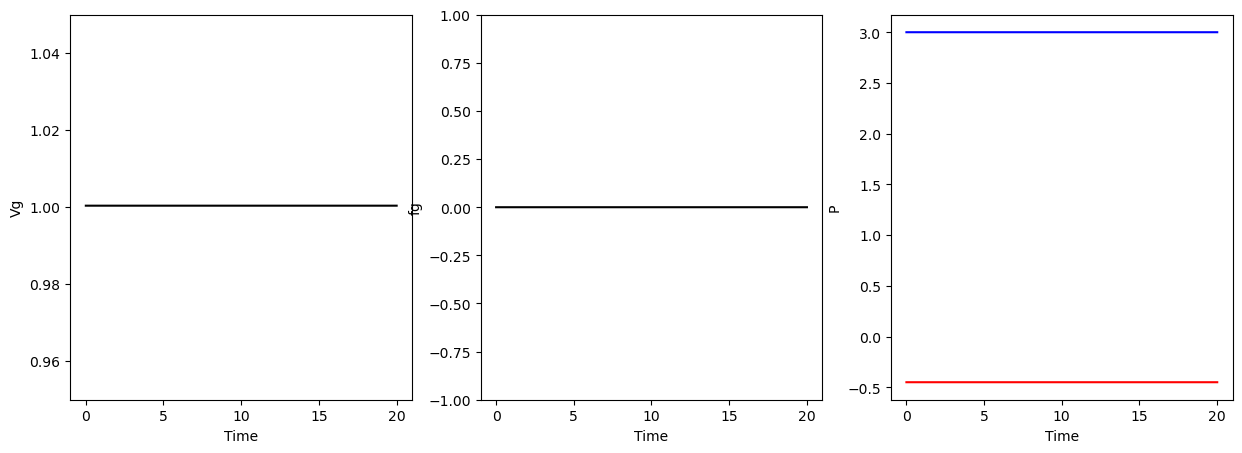

In [19]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
sns.lineplot(x = "Time", y = "Vg", data=df, ax=ax[0], color='k')
ax[0].set_ylim([0.95, 1.05])
sns.lineplot(x = "Time", y = "fg", data=df, ax=ax[1], color='k')
ax[1].set_ylim([-1, 1])
sns.lineplot(x = "Time", y = "P", data=df, ax=ax[2], color='b')
sns.lineplot(x = "Time", y = "Q", data=df, ax=ax[2], color='r')

In [21]:
Vgridbase = 154

Vgini = Vgrid*Vgridbase
fgini = fgrid+60

Vgini, fgini

(array([154.0616, 154.0616, 154.0616, ..., 154.0616, 154.0616, 154.0616]),
 array([60., 60., 60., ..., 60., 60., 60.]))

In [22]:
Va8step = math.floor(170/timestep)
Va8 = np.zeros((Va8step, 3))
Va8.shape

for k in range(Va8.shape[0]):
    Va8[k, 0] = k*timestep
    
    if k*timestep<20:
        Va8[k,1] = Vgini[k]
        Va8[k, 2] = fgini[k]
    elif k*timestep<50:
        Va8[k,1] = 0.92*Vgridbase
        Va8[k, 2] = 60
    elif k*timestep<80:
        Va8[k,1] = 0.95*Vgridbase
        Va8[k, 2] = 60
    elif k*timestep<110:
        Va8[k,1] = 1*Vgridbase
        Va8[k, 2] = 60
    elif k*timestep<140:
        Va8[k,1] = 1.05*Vgridbase
        Va8[k, 2] = 60
    else:
        Va8[k,1] = 1.08*Vgridbase
        Va8[k, 2] = 60

Va8df = pd.DataFrame(Va8, columns=["time","Vg","fg"])

<AxesSubplot: xlabel='time', ylabel='fg'>

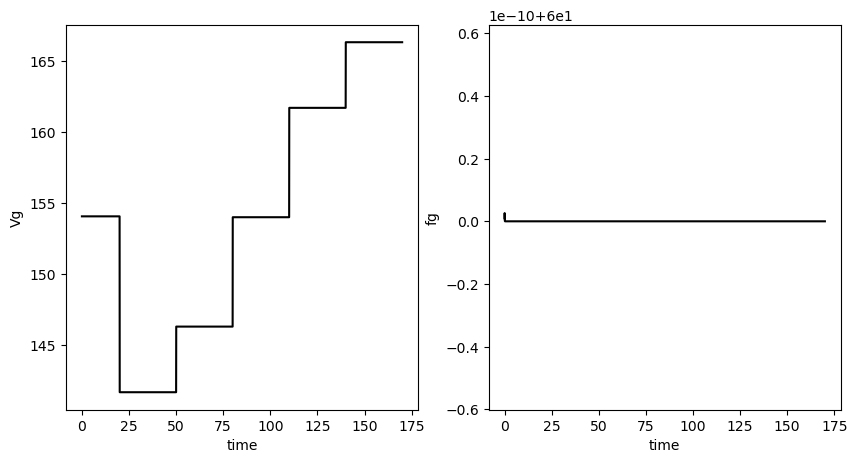

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.lineplot(x = "time", y = "Vg", data=Va8df, ax=ax[0], color='k')
sns.lineplot(x = "time", y = "fg", data=Va8df, ax=ax[1], color='k')

In [24]:
Va8df.to_csv('VPLBA8.plb', index = False, header=False)
shutil.move(runfolder+'/'+'VPLBA8.plb', runfolder+'/'+'VPLBA8.plb')

'C:/Users/smartgrid_AI/Documents/kms/netzero/VPLBA8.plb'

In [25]:
Fa5step = math.floor(110/timestep)
Fa5 = np.zeros((Fa5step, 3))

for k in range(Fa5.shape[0]):
    Fa5[k, 0] = k*timestep
    
    if k*timestep<20:
        Fa5[k,1] = Vgini[k]
        Fa5[k, 2] = fgini[k]
    elif k*timestep<50:
        Fa5[k,1] = Vgini[-1]
        Fa5[k, 2] = 60.5
    elif k*timestep<80:
        Fa5[k,1] = Vgini[-1]
        Fa5[k, 2] = 61
    else:
        Fa5[k,1] = Vgini[-1]
        Fa5[k, 2] = 61.5

Fa5df = pd.DataFrame(Fa5, columns=["time","Vg","fg"])

<AxesSubplot: xlabel='time', ylabel='fg'>

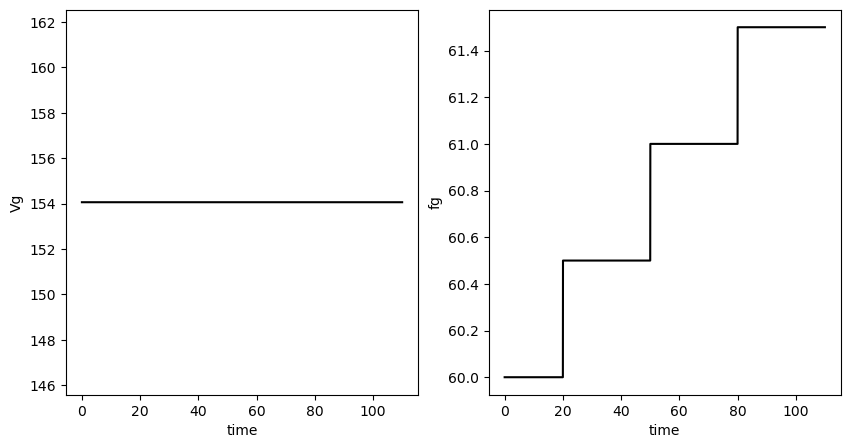

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.lineplot(x = "time", y = "Vg", data=Fa5df, ax=ax[0], color='k')
sns.lineplot(x = "time", y = "fg", data=Fa5df, ax=ax[1], color='k')

In [27]:
Fa5df.to_csv('FPLBA5.plb', index = False, header=False)
shutil.move(runfolder+'/'+'FPLBA5.plb', runfolder+'/'+'FPLBA5.plb')

'C:/Users/smartgrid_AI/Documents/kms/netzero/FPLBA5.plb'

In [28]:
Fa10step = math.floor(110/timestep)
Fa10 = np.zeros((8,Fa10step, 3))

for k in range(Fa10.shape[1]):
    Fa10[:, k, 0] = k*timestep
    
    if k*timestep<20:
        Fa10[:, k,1] = Vgini[k]
        Fa10[:, k, 2] = fgini[k]
    elif k*timestep<50:
        Fa10[:, k,1] = Vgini[-1]
        Fa10[:, k, 2] = 60
    elif k*timestep<80:
        Fa10[:, k,1] = Vgini[-1]
        Fa10[0, k, 2] = 60.5
        Fa10[1, k, 2] = 61.0
        Fa10[2, k, 2] = 61.5
        Fa10[3, k, 2] = 59.5
        Fa10[4, k, 2] = 59.0
        Fa10[5, k, 2] = 58.5
        Fa10[6, k, 2] = 58.0
        Fa10[7, k, 2] = 57.5
    else:
        Fa10[:, k,1] = Vgini[-1]
        Fa10[:, k, 2] = 60

Fa10_1df = pd.DataFrame(Fa10[0,:,:], columns=["time","Vg","fg"])
Fa10_2df = pd.DataFrame(Fa10[1,:,:], columns=["time","Vg","fg"])
Fa10_3df = pd.DataFrame(Fa10[2,:,:], columns=["time","Vg","fg"])
Fa10_4df = pd.DataFrame(Fa10[3,:,:], columns=["time","Vg","fg"])
Fa10_5df = pd.DataFrame(Fa10[4,:,:], columns=["time","Vg","fg"])
Fa10_6df = pd.DataFrame(Fa10[5,:,:], columns=["time","Vg","fg"])
Fa10_7df = pd.DataFrame(Fa10[6,:,:], columns=["time","Vg","fg"])
Fa10_8df = pd.DataFrame(Fa10[7,:,:], columns=["time","Vg","fg"])

<AxesSubplot: xlabel='time', ylabel='fg'>

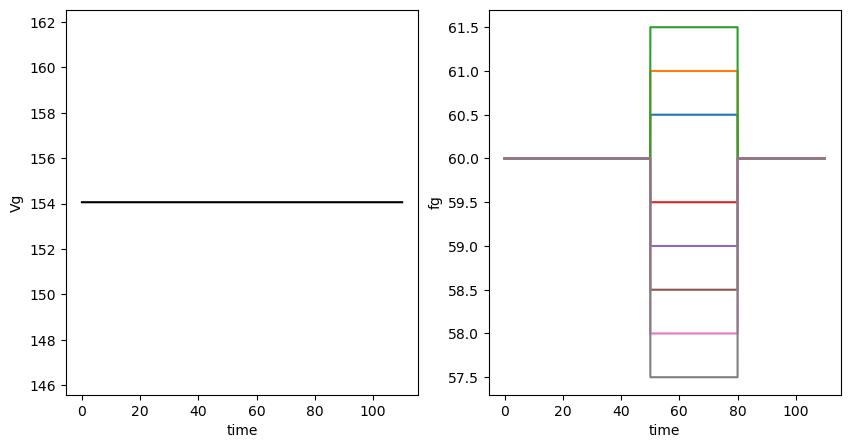

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.lineplot(x = "time", y = "Vg", data=Fa10_1df, ax=ax[0], color='k')
sns.lineplot(x = "time", y = "fg", data=Fa10_1df, ax=ax[1])
sns.lineplot(x = "time", y = "fg", data=Fa10_2df, ax=ax[1])
sns.lineplot(x = "time", y = "fg", data=Fa10_3df, ax=ax[1])
sns.lineplot(x = "time", y = "fg", data=Fa10_4df, ax=ax[1])
sns.lineplot(x = "time", y = "fg", data=Fa10_5df, ax=ax[1])
sns.lineplot(x = "time", y = "fg", data=Fa10_6df, ax=ax[1])
sns.lineplot(x = "time", y = "fg", data=Fa10_7df, ax=ax[1])
sns.lineplot(x = "time", y = "fg", data=Fa10_8df, ax=ax[1])

In [30]:
Fa10_1df.to_csv('FPLBA10_1.plb', index = False, header=False)
shutil.move(runfolder+'/'+'FPLBA10_1.plb', runfolder+'/'+'FPLBA10_1.plb')
Fa10_2df.to_csv('FPLBA10_2.plb', index = False, header=False)
shutil.move(runfolder+'/'+'FPLBA10_2.plb', runfolder+'/'+'FPLBA10_2.plb')
Fa10_3df.to_csv('FPLBA10_3.plb', index = False, header=False)
shutil.move(runfolder+'/'+'FPLBA10_3.plb', runfolder+'/'+'FPLBA10_3.plb')
Fa10_4df.to_csv('FPLBA10_4.plb', index = False, header=False)
shutil.move(runfolder+'/'+'FPLBA10_4.plb', runfolder+'/'+'FPLBA10_4.plb')
Fa10_5df.to_csv('FPLBA10_5.plb', index = False, header=False)
shutil.move(runfolder+'/'+'FPLBA10_5.plb', runfolder+'/'+'FPLBA10_5.plb')
Fa10_6df.to_csv('FPLBA10_6.plb', index = False, header=False)
shutil.move(runfolder+'/'+'FPLBA10_6.plb', runfolder+'/'+'FPLBA10_6.plb')
Fa10_7df.to_csv('FPLBA10_7.plb', index = False, header=False)
shutil.move(runfolder+'/'+'FPLBA10_7.plb', runfolder+'/'+'FPLBA10_7.plb')
Fa10_8df.to_csv('FPLBA10_8.plb', index = False, header=False)
shutil.move(runfolder+'/'+'FPLBA10_8.plb', runfolder+'/'+'FPLBA10_8.plb')

'C:/Users/smartgrid_AI/Documents/kms/netzero/FPLBA10_8.plb'

In [31]:
Va11step = math.floor(80/timestep)
Va11 = np.zeros((5, Va11step, 3))

for k in range(Va11.shape[1]):
    Va11[:,k, 0] = k*timestep
    
    if k*timestep<20:
        Va11[:,k,1] = Vgini[k]
        Va11[:,k, 2] = fgini[k]
    elif k*timestep<50:
        Va11[:,k,1] = Vgridbase
        Va11[:,k, 2] = 60
    elif k*timestep<51:
        Va11[0,k,1] = 0.9*Vgridbase
        Va11[1,k,1] = 0.5*Vgridbase
        Va11[2,k,1] = 0.0*Vgridbase
        Va11[3,k,1] = 1.1*Vgridbase
        Va11[4,k,1] = 1.2*Vgridbase
        Va11[:,k, 2] = 60
    else:
        Va11[:,k,1] = Vgridbase
        Va11[:,k, 2] = 60

Va11_1df = pd.DataFrame(Va11[0,:,:], columns=["time","Vg","fg"])
Va11_2df = pd.DataFrame(Va11[1,:,:], columns=["time","Vg","fg"])
Va11_3df = pd.DataFrame(Va11[2,:,:], columns=["time","Vg","fg"])
Va11_4df = pd.DataFrame(Va11[3,:,:], columns=["time","Vg","fg"])
Va11_5df = pd.DataFrame(Va11[4,:,:], columns=["time","Vg","fg"])

<AxesSubplot: xlabel='time', ylabel='fg'>

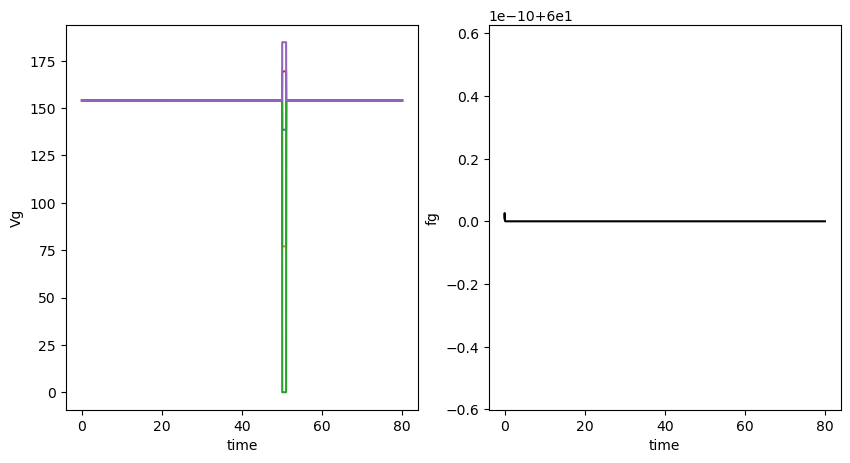

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.lineplot(x = "time", y = "Vg", data=Va11_1df, ax=ax[0])
sns.lineplot(x = "time", y = "Vg", data=Va11_2df, ax=ax[0])
sns.lineplot(x = "time", y = "Vg", data=Va11_3df, ax=ax[0])
sns.lineplot(x = "time", y = "Vg", data=Va11_4df, ax=ax[0])
sns.lineplot(x = "time", y = "Vg", data=Va11_5df, ax=ax[0])
sns.lineplot(x = "time", y = "fg", data=Va11_1df, ax=ax[1], color='k')

In [33]:
Va11_1df.to_csv('VPLBA11_1.plb', index = False, header=False)
shutil.move(runfolder+'/'+'VPLBA11_1.plb', runfolder+'/'+'VPLBA11_1.plb')
Va11_2df.to_csv('VPLBA11_2.plb', index = False, header=False)
shutil.move(runfolder+'/'+'VPLBA11_2.plb', runfolder+'/'+'VPLBA11_2.plb')
Va11_3df.to_csv('VPLBA11_3.plb', index = False, header=False)
shutil.move(runfolder+'/'+'VPLBA11_3.plb', runfolder+'/'+'VPLBA11_3.plb')
Va11_4df.to_csv('VPLBA11_4.plb', index = False, header=False)
shutil.move(runfolder+'/'+'VPLBA11_4.plb', runfolder+'/'+'VPLBA11_4.plb')
Va11_5df.to_csv('VPLBA11_5.plb', index = False, header=False)
shutil.move(runfolder+'/'+'VPLBA11_5.plb', runfolder+'/'+'VPLBA11_5.plb')

'C:/Users/smartgrid_AI/Documents/kms/netzero/VPLBA11_5.plb'

In [34]:
Va12step = math.floor(80/timestep)
Va12 = np.zeros((3, Va12step, 3))

for k in range(Va12.shape[1]):
    Va12[:,k, 0] = k*timestep
    
    if k*timestep<20:
        Va12[:,k, 1] = Vgini[k]
        Va12[:,k, 2] = fgini[k]
    elif k*timestep<50:
        Va12[:,k, 1] = Vgridbase
        Va12[:,k, 2] = 60
    elif k*timestep<51:
        Va12[0,k,1] = 0.9*Vgridbase
        Va12[1,k,1] = 0.5*Vgridbase
        Va12[2,k,1] = 0.0*Vgridbase
        Va12[:,k,2] = 60
    else:
        Va12[:,k,1] = Vgridbase
        Va12[:,k,2] = 60

Va12_1df = pd.DataFrame(Va12[0,:,:], columns=["time","Vg","fg"])
Va12_2df = pd.DataFrame(Va12[1,:,:], columns=["time","Vg","fg"])
Va12_3df = pd.DataFrame(Va12[2,:,:], columns=["time","Vg","fg"])

<AxesSubplot: xlabel='time', ylabel='fg'>

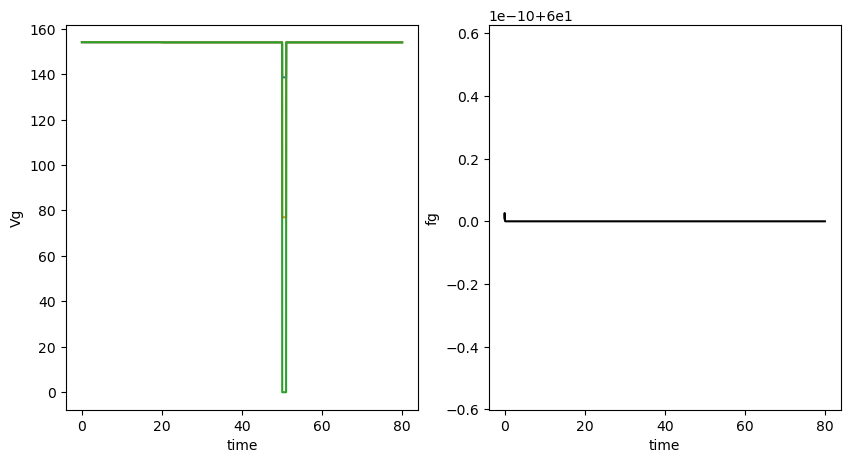

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.lineplot(x = "time", y = "Vg", data=Va12_1df, ax=ax[0])
sns.lineplot(x = "time", y = "Vg", data=Va12_2df, ax=ax[0])
sns.lineplot(x = "time", y = "Vg", data=Va12_3df, ax=ax[0])
sns.lineplot(x = "time", y = "fg", data=Va11_1df, ax=ax[1], color='k')

In [36]:
Va12_1df.to_csv('VPLBA12_1.plb', index = False, header=False)
shutil.move(runfolder+'/'+'VPLBA12_1.plb', runfolder+'/'+'VPLBA12_1.plb')
Va12_2df.to_csv('VPLBA12_2.plb', index = False, header=False)
shutil.move(runfolder+'/'+'VPLBA12_2.plb', runfolder+'/'+'VPLBA12_2.plb')
Va12_3df.to_csv('VPLBA12_3.plb', index = False, header=False)
shutil.move(runfolder+'/'+'VPLBA12_3.plb', runfolder+'/'+'VPLBA12_3.plb')

'C:/Users/smartgrid_AI/Documents/kms/netzero/VPLBA12_3.plb'